In [1]:
import numpy as np
import matplotlib.pyplot as plt



In [2]:
from typing import Union
from collections.abc import Callable
from functools import partial

from ipynb.fs.defs.rk4 import rk4, euler_forward

In [3]:
"""
data structure  data[i, j, k, m],
with i and j describing the place on the grid,
k=S,I,R and m=x0, x1, x2, ... (awareness)
"""

'\ndata structure  data[i, j, k, m],\nwith i and j describing the place on the grid,\nk=S,I,R and m=x0, x1, x2, ... (awareness)\n'

In [4]:
def g(roh,Sis,S):
    res = 0
    Sis 
    for i in range(0,len(Sis)):
        res += Sis[i]/S*(roh)**i
    return res

def g2(rho, S):
    sus = susceptibility(rho, S.shape[0])
    return np.sum(S*(1-sus[:, None]), axis=0)

In [5]:
def susceptibility(rho: float, n: int) -> np.ndarray:  # factor which reduces susceptibility based on awareness
    # awareness is reduced by a constant factor for each distance it traveles
    # the last slot is for no awareness -> no susceptibility reduction
    sus = np.array([*[1-rho**i for i in range(n-1)], 1])
    return sus

In [44]:
def awareness_SIR(t: float,y: np.ndarray, alpha: float=0.1, beta: float = 0.5, gamma: float = 0.4,\
    omega: float=0.7, lam: float=0.5, rho: float=0.7) -> np.ndarray:
    """
    differential SIR model
    working on a grid
    y: function value, here data structure with grid, 3rd row describes SIR
    return: dy
    """
    dy = np.zeros(shape=y.shape)  # change in y, initialized as empty array to be filled

    # indexing: dy[i, j, k, m]
    # i, j: row, column of individual on grid
    # k: infection state: S,I,R
    # m: awareness state: 0,1,2,...,n;np.inf  (the last state is the compleatly unaware state,
    # which is the state at the beginning and the state beneath a cutoff value given by the maximal
    # length of an awareness chain)
    # Each individual (at a location (i, j) is in a superposition of different states.
    # Each of the state is associated with a probability of being in that state, which is stored in y[i,j,k,m]
    # The probability for all states together must equal one for each individual.

    # because of correlations between the SIR state and the awareness state,
    # all possible states (combinations of SIR state and awareness state) have to be kept seperatly
    # Example: If I'm statistically infected, I might notice the infection and thus have a high awareness,
    # but this high awareness is coupled to my infection and thus won't lower the probability
    # of me becomimg infected)

    # Because every possible state is being tracked, a good check will be the sum of the states
    # for each individual, whcih must be equal to one (the probability of finding an individual
    # in any possible state must be 1)

    # Note: This implementation is to be used with a small step size as probabilities don't add up
    # for large probabilities.
    # Example: I have two contacts who can each infect me with a probability of 0.4 (40%). 
    # Then the probability of me beconing infected is
    # 1 - (1-0.4)*(1-0.4) = 1 - 0.6^2 = 0.64 (=64% and not 80%)
    # for small probabilities (-> small time steps) one can add the probabilities:
    # 1 - (1-alpha)*(1-beta) = 1 - (1 - alpha - beta + alpha*beta) = alpha + beta - alpha*beta,
    # which is approximately alpha + beta, if alpha*beta is sufficiently small so it can be neglected
    
    # indexing in python (ignoring data types):
    # Example:
    # data = np.array(
    #     [[1, 2, 3],
    #      [4, 5, 6],
    #      [7, 8, 9]]
    # )
    #
    # each axis (also called index or dimension) of the array is separated by a comma when indexing
    #
    # data[i, j] selects the data at the location (i, j), which can in itself be an array:
    # 
    # data[0, 0] returns 1  (indexing starts at zero)
    # data[0, 1] returns 2
    #
    # data[0] returns [1, 2, 3]  (the first row)
    # 
    # to get the values stored in the last column we can use
    # data[:, 2] = [3, 6, 9]  (for each row return the value at location 2)
    # 
    # data[0, 1:] returns [2, 3]  (for row zero return the values starting at location 1 (included))
    # data[0, :2] returns [1, 2]  (for row zero return the values until location 2 (not included))
    # data[0, :-1] returns [1, 2] (for row zero return the values until the last location (not included))
    #
    # operations on numpy arrays are done element wise
    # data[-1] - data[:, -1] = [7, 8, 9] - [3, 6, 9] = [4, 2, 0]
    # 2*data[1:, :-1] = 2* [[4, 5], [7, 8]] = [[8, 10], [14, 16]]
    #
    # use -1 to access the last value in a certain axis (index/dimension)
    #
    # one can use ... to fill for an unknown amount of axes
    # data[:, 0] returns [1, 4, 7]
    # data[..., 0] returns [1, 4, 7]
    # data[0, ..., 0] returns 1
    #
    # to add a new axis, use data[:, :, None] etc.


    ## SIR model  ##

    #change in infection and susceptibility

    # introducing shortcuts to access different parts of the grid
    # (these can replace the first two indices when accessing the data)
    upper = np.s_[:-1, :]  # whole grid except for the last row
    lower = np.s_[1:, :]  # everything except the first row
    left = np.s_[:, :-1]  # everything except the last column
    right = np.s_[:, 1:]  # everything except the first column

    origin = [upper, lower, left, right]  # to be iterated over
    destination = [lower, upper, right, left]  # "opposite" to origin, order must "match" origin

    '''
    dy[1:,:,1,:] += beta*y[:-1,:,1,:]*y[1:,:,0,:]  # infections downwards
    # change in Infection += beta*I(neighbour above)*S(own)
    dy[1:,:,0,:] -= beta*y[:-1,:,1,:]*y[1:,:,0,:] 
    # change in S -= change in Infection we just calculated
    # (moving people from one compartment to the next one)

    # TODO: implement reduced susceptibility based on awareness
    # new rate: beta*(1-roh**i)

    dy[:-1,:,1,:] += beta*y[1:,:,1,:]*y[:-1,:,0,:] # infections upwards
    dy[:-1,:,0,:] -= beta*y[1:,:,1,:]*y[:-1,:,0,:] 

    dy[:,1:,1,:] += beta*y[:,:-1,1,:]*y[:,1:,0,:] # infections towards the right
    dy[:,1:,0,:] -= beta*y[:,:-1,1,:]*y[:,1:,0,:] 

    dy[:,:-1,1,:] += beta*y[:,1:,1,:]*y[:,:-1,0,:] # infections towards the left
    dy[:,:-1,0,:] -= beta*y[:,1:,1,:]*y[:,:-1,0,:] 
    '''

    # TODO: dy[target, 1, :] does NOT work, use
    # dy[(*target, *np.s_[1, :])] or dy[(*target, np.s_[1], np.s_[:])] instead  -> is this now unreadable?
    # alternatively use dy[target][..., 1, :]
    # will get this working by monday - N.

    for source, target in zip(origin, destination):  # iterating over the 4 neighbor cells 
        # for each element in origin and its corresponding element in destination
        sus = susceptibility(rho, y.shape[3])
        nt = sus*y[target][..., 0, :]
        ns = np.sum(y[source][..., 1, 1:], axis=-1)[..., None]  # with self-isolation!!!
        dy[target][..., 1, :] += beta*nt*ns
        dy[target][..., 0, :] -= beta*nt*ns
    #recovery
    I = y[..., 1, :]  # infections
    dy[..., 1, :] -= gamma*I  # removing infections from the infected compartment
    dy[..., 2, :] += gamma*I  # and adding them to the recovered compartment
    # the awareness state does not affect the recovery process
    # and is kept when moving from infected to recovered
    

    ## awareness ##
    #information generation (only acts on infected individuals, indepentent of previous awareness state)
    
    # adding to compartment with the highest awareness;
    # the sum over the last axis (all possible awareness states, which equal one in total so
    # np.sum(I, axis=-1) resembles the amount of infection, independent
    # of the awareness)
    dy[..., 1, 0] += omega*np.sum(I, axis=-1)
    dy[..., 1, :] -= omega*I  # remove 
    
    # Q: shouldnt it be dy[:,:,1,0]?
    # -> yes, the movement is from the (I, X_i) to the (I, X_0) state
    # because the movement comes from different states, we have to add them up -> np.sum()
    # we also have to remove probabilities from the uninformed states
    # so that the total probability for all states for an individual is always equal to one



    # awareness transmission
    for source, target in zip(origin, destination):
        # for each element in origin and its corresponding element in destination
        for m in range(1, y.shape[3]-1):  # iterate over all awareness levels from "1" to "n" 
            nt = np.sum(y[target][..., :, m+1:], axis=3)
            ns = np.sum(y[source][..., :, m-1], axis=2)[..., None]
            dy[target][..., :, m] += alpha*nt*ns
        for m in range(2, y.shape[3]):  # iterate over all awareness levels from "2" to "np.inf"
            nt = y[target][..., :, m]
            ns = np.sum(y[source][..., :, :m-1], axis=(2, 3))[..., None]
            dy[target][..., :, m] -= alpha*nt*ns


    #dy[1:,:,:,1:] += alpha*y[:-1,:,:,:-1]  # here the growth of information only depends on my neighbor
    # and not on myself. However, if I were compleatly in the informed state X_0,
    # then the probability for X_i should not increase 
    #dy[:-1,:,:,1:] += alpha*y[1:,:,:,:-1]
    #dy[:,1:,:,1:] += alpha*y[:,:-1,:,:-1]
    #dy[:,:-1,:,1:] += alpha*y[:,1:,:,:-1]

    #Q: szenario: imagine two neighbours telling me information,
    #   currently, both information % added, but is this what happens?
    # -> yes, you can add the rates together, imagine someone telling you the same information
    # but at twice the frequency, then the chance of hearing it in the first second will be doubled
    # (assuming the probability of hearing it within a second is very small)
    # problems arise when the time steps are too large
    # and the rates then cause a large probability within a single time interval

    # awareness fading (not depending on S,I,R)
    dy[..., :, 1:] += lam*y[..., :, :-1]  # add awareness one level below
    dy[..., :, :-1] -= lam*y[..., :, :-1]  # and remove the moved ones

    return dy
#TODO: comb of S and X
#TODO: unterscheiden zwischen S,I,R Informationsgüte

In [64]:
y0 = np.zeros(shape=(30,30,3,5))
#print(y0)
y0[:,:,0,-1] = 1  # everyone is susceptible, no information at the start
#y0[14,14,1,-1] = 1  # one infection
#y0[14,14,0,-1] = 0  # remove infected from susceptible pool


y0[14, 14, 1, -1] = 1
y0[14, 14, 0, -1] = 0


# model
# alpha: awareness transmission
# beta: virus transmission
# gamma: virus recovery rate
# omega: awareness creation
# lam: awareness fading over time
# rho: susceptibility reduction (rh0=0.9 means 90% reduction for first level, 81% reduction for second level etc.)
RHO = 0.5
model = partial(awareness_SIR, alpha=5, beta=0.25, gamma=0.2, omega=0.4, lam=0.1, rho=RHO)

t,y = rk4(model,y0,0,300,3000)
print(susceptibility(RHO, y.shape[3]))

# TODO: dy[target, 1, :] does NOT work, use
# dy[(*target, *np.s_[1, :])] or dy[(*target, np.s_[1], np.s_[:])] instead  -> is this now unreadable?
# alternatively use dy[target][..., 1, :]
# will get this working by monday - N.

[0.    0.5   0.75  0.875 1.   ]


probability conserved: True


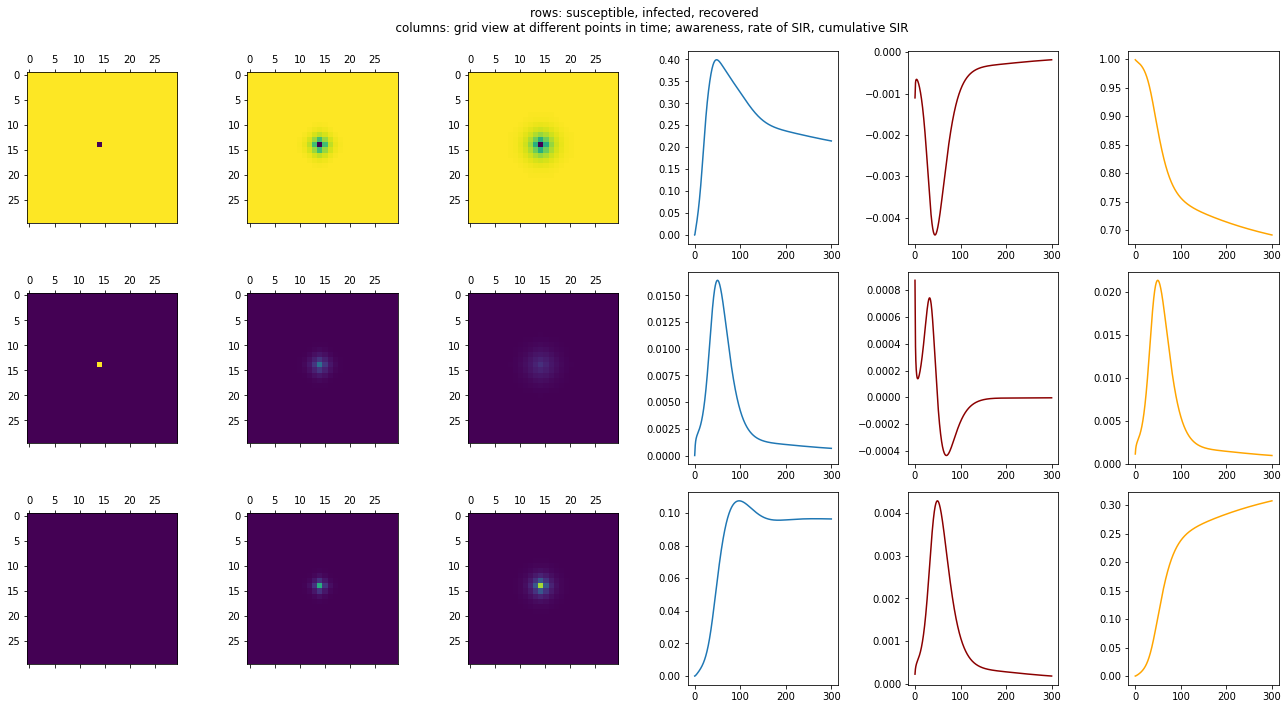

In [66]:
fig = plt.figure(figsize=(18, 10))
axes = fig.subplots(3, 6).reshape(3, 6)
SIR = np.sum(y, axis=3)  # sum over awareness axis, new axes: i, j, SIR, time
S = SIR[:, :, 0]
I = SIR[:, :, 1]
R = SIR[:, :, 2]
for i in range(3):
    aw = np.average(y[:, :, i, :], axis=(0, 1))  # average over grid, susceptible only -> indices: awareness
    awareness_level = g2(RHO, aw)
    axes[i, 3].plot(t, awareness_level)

    n = np.average(SIR[:, :, i], axis=(0, 1))
    axes[i, 5].plot(t, n, 'orange')

    dt = t[1:]-t[:-1]
    dn = n[1:]-n[:-1]
    t_av = 0.5*(t[1:]+t[:-1])
    axes[i, 4].plot(t_av, dn/dt, 'darkred')

kwargs = {
    'interpolation': 'nearest',
    'vmin': 0,
    'vmax': 1
}
print(f'probability conserved: {np.array([np.sum(y[i, j], axis=(0, 1)).all() for i in range(y.shape[0]) for j in range(y.shape[1])]).all()}')
axes[0, 0].matshow(S[..., 0], **kwargs)
axes[0, 1].matshow(S[..., 50], **kwargs)
axes[0, 2].matshow(S[...,100], **kwargs)
axes[1, 0].matshow(I[..., 0], **kwargs)
axes[1, 1].matshow(I[..., 50], **kwargs)
axes[1, 2].matshow(I[...,100], **kwargs)
axes[2, 0].matshow(R[..., 0], **kwargs)
axes[2, 1].matshow(R[..., 50], **kwargs)
axes[2, 2].matshow(R[...,100], **kwargs)

fig.suptitle('rows: susceptible, infected, recovered\n\
    columns: grid view at different points in time; awareness, rate of SIR, cumulative SIR')

plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ac0f8ce2-3132-47be-a4d1-6216636e93ff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>